In [1]:
import pandas as pd
import numpy as np
from prophet import Prophet
import joblib


from modeling_prophet import (
    detect_dominant_periods,
    prophet_hyperparam_grid_search,
    plot_forecast_with_fit,
    evaluate_forecast_performance,
    prophet_residual_diagnostics
)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data

In [2]:
df = pd.read_excel('tsdata1.xlsx')
df['Date'] = pd.to_datetime(df['Date'])

# Shift features
# df['x1_lag1'] = df['x1_spend'].shift(1)
# df['x2_lag1'] = df['x2_spend'].shift(1)

In [3]:
# Split data
df_prophet = df.rename(columns={'Date': 'ds', 'weekly_sales': 'y'})
split_index = int(len(df_prophet) * 0.8)
train_prophet = df_prophet.iloc[:split_index].copy()
test_prophet = df_prophet.iloc[split_index:].copy()

# Add lagged features
# train_prophet['x2_spend_lag1'] = train_prophet['x2_spend'].shift(1).bfill()
# test_prophet['x2_spend_lag1'] = test_prophet['x2_spend'].shift(1).bfill()

In [4]:
# Transformation
# Log transformation
# train_prophet['y'] = np.log1p(train_prophet['y'])

# Box-Cox transformation
# train_prophet['y'], fitted_lambda = stats.boxcox(train_prophet['y'] + 1)
# test_prophet['y'] = stats.boxcox(test_prophet['y'] + 1, lmbda=fitted_lambda)
# print(train_prophet)

# Smoothing
# window_size = 2
# df['weekly_sales_smooth'] = df['weekly_sales'].rolling(window=window_size, center=True).mean()
# plot_rolling_statistics(df['weekly_sales'], window=window_size)

In [5]:
# Check dominant peroids
dominant = detect_dominant_periods(train_prophet['y'], sampling_rate=1, top_n=10, threshold_quantile=0.9)
print(dominant)

   frequency     period     amplitude
0   0.140625   7.111111  37426.618302
1   0.429688   2.327273  36861.900517
2   0.187500   5.333333  36576.602706
3   0.023438  42.666667  31903.575709
4   0.125000   8.000000  31672.536881
5   0.062500  16.000000  31439.180274
6   0.398438   2.509804  30243.789334


# Univariate

In [6]:
# Gird search
fourier_order_grid = [
    [4, 4, 4],
    [3, 3, 3],
    [2, 3, 4]
]
best_config, results_df = prophet_hyperparam_grid_search(
    train_df=train_prophet,
    changepoint_scale_list=[0.05, 0.1, 0.2],
    fourier_order_grid=fourier_order_grid,
    dominant_periods=[7.111, 2.333, 5.333],
    seasonality_mode='multiplicative'
)
print(results_df.head(20))

00:52:05 - cmdstanpy - INFO - Chain [1] start processing
00:52:05 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/2 [00:00<?, ?it/s]00:52:05 - cmdstanpy - INFO - Chain [1] start processing
00:52:05 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 1/2 [00:00<00:00,  3.23it/s]00:52:05 - cmdstanpy - INFO - Chain [1] start processing
00:52:05 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 2/2 [00:00<00:00,  5.83it/s]
00:52:05 - cmdstanpy - INFO - Chain [1] start processing
00:52:05 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/2 [00:00<?, ?it/s]00:52:06 - cmdstanpy - INFO - Chain [1] start processing
00:52:06 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 1/2 [00:00<00:00,  4.18it/s]00:52:06 - cmdstanpy - INFO - Chain [1] start processing
00:52:06 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 2/2 [00:00<00:00,  7.38it/s]
00:52:06 - cmdstanpy - INFO - Chain [1] start processing
00:52:06 

Best Config (cps, prior_scale, [fourier_orders]): (np.float64(0.05), np.float64(0.1), [2, 3, 4])
Best MAPE: 146.04%
MAE: 7482.93, RMSE: 13784.40
   changepoint_prior_scale  prior_scale fourier_order_list         mape  \
0                     0.05          0.1          [2, 3, 4]   146.043905   
1                     0.20          0.1          [3, 3, 3]   179.160691   
2                     0.10          0.1          [2, 3, 4]  1530.491617   
3                     0.20          0.1          [2, 3, 4]  1746.509365   
4                     0.05          0.1          [4, 4, 4]  2987.325481   
5                     0.20          0.1          [4, 4, 4]  3036.145889   
6                     0.10          0.1          [4, 4, 4]  3057.525325   
7                     0.10          0.1          [3, 3, 3]  3722.113089   
8                     0.05          0.1          [3, 3, 3]  3774.091012   

             mae           rmse  
0    7482.931333   13784.395264  
1    9761.417742   15116.051660  
2 

00:52:10 - cmdstanpy - INFO - Chain [1] start processing
00:52:10 - cmdstanpy - INFO - Chain [1] done processing


Forecast Performance:
MAE   : 1219.36
RMSE  : 1697.13
MAPE  : 33.87%
SMAPE : 23.74%


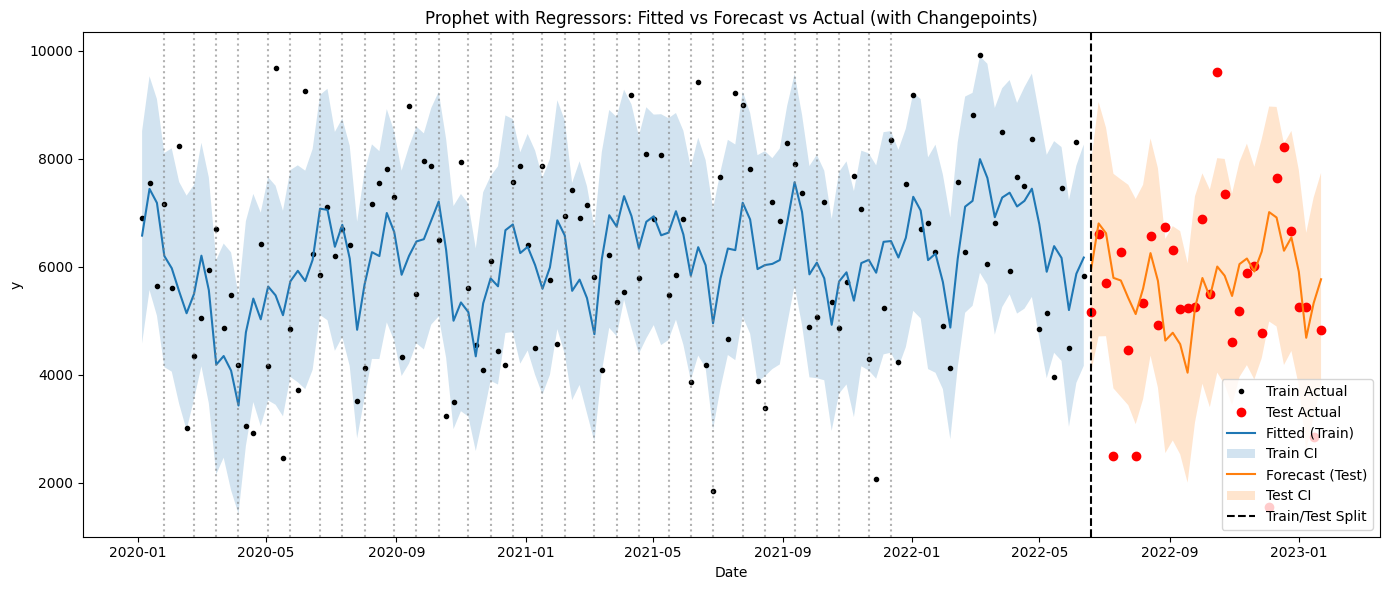

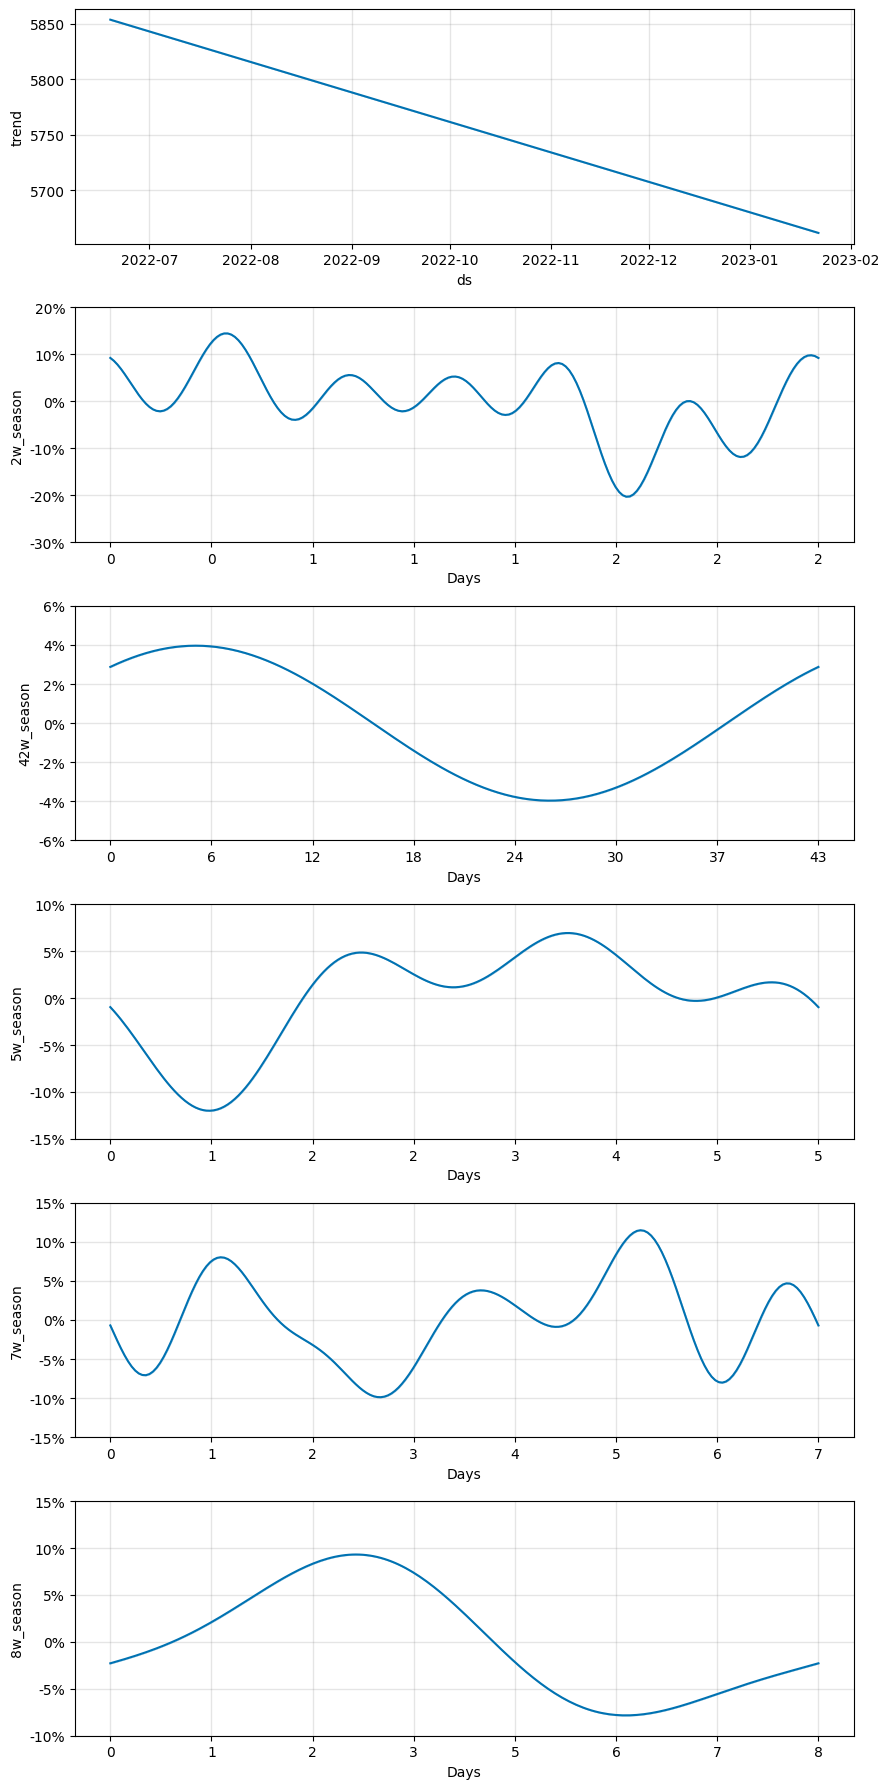

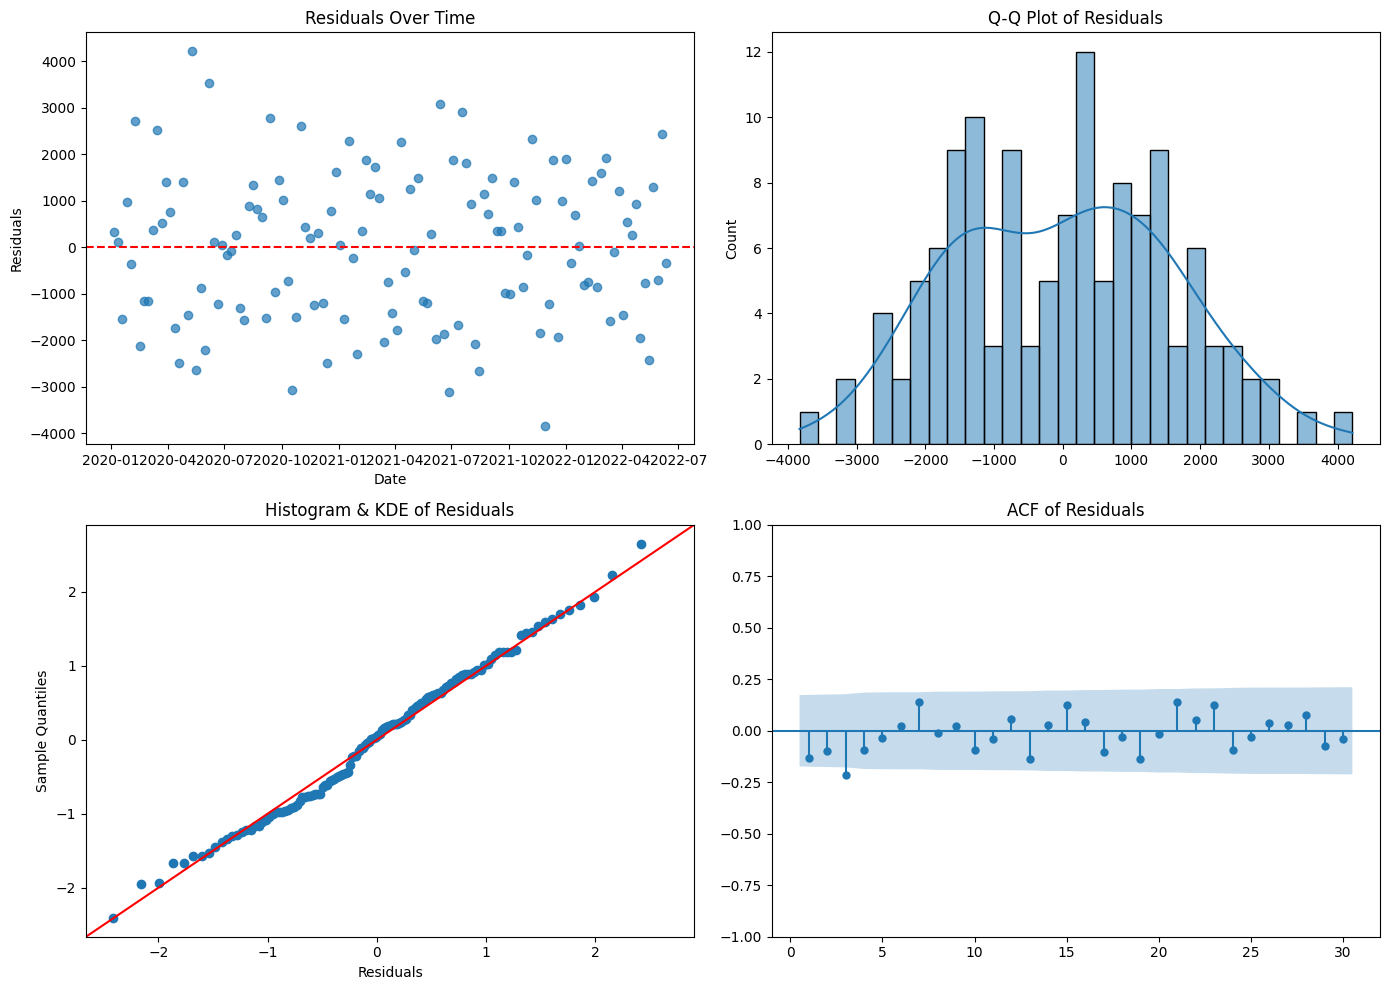

In [7]:
# Build the model
model_uni = Prophet(
    seasonality_mode='multiplicative',
    yearly_seasonality=False, 
    changepoint_prior_scale=0.1,
    n_changepoints=30
)

# Add seasonality
model_uni.add_seasonality(name='7w_season', period=7.111, fourier_order=6)
model_uni.add_seasonality(name='2w_season', period=2.33, fourier_order=7)
model_uni.add_seasonality(name='5w_season', period=5.333, fourier_order=3)
model_uni.add_seasonality(name='42w_season', period=42.667, fourier_order=1)
model_uni.add_seasonality(name='8w_season', period=8, fourier_order=2)

# Train the model
model_uni.fit(train_prophet)

# Predict future values
forecast_prophet = model_uni.predict(test_prophet)

evaluate_forecast_performance(test_prophet['y'], forecast_prophet['yhat'])
plot_forecast_with_fit(model_uni, train_prophet, test_prophet, forecast_prophet)
model_uni.plot_components(forecast_prophet)
prophet_residual_diagnostics(model_uni, train_prophet)


**Model Fit Assessment**
- By leveraging the FFT approach, several potential frequencies (e.g., 2.33 weeks, 5.333 weeks, 7.111 weeks, 8 weeks, and 42.667 weeks) are identified and implemented as custom seasonalities in Prophet. This enables the model to capture complex recurring patterns that might not align neatly with standard weekly or yearly cycles.
- The Prophet model used a multiplicative seasonality mode and included up to 30 changepoints (`changepoint_prior_scale=0.1`). This setup provided flexibility to adapt to subtle trend shifts over time.

**Residual Diagnostics**
- The residual ACF plot shows that all autocorrelation coefficients fall within the 95% confidence bounds, indicating no significant temporal correlation left unexplained by the model.

- The histogram and Q–Q plot of residuals suggest an approximately Gaussian distribution. While mild deviations appear in the tails, they are within acceptable bounds for real-world applications. The residuals over time appear centered around zero, with no observable trend or heteroskedasticity.

In [55]:
# Save model
joblib.dump(model_uni, 'models_univariate_prophet.pkl')

['models_univariate_prophet.pkl']

# Multivariate

In [9]:
# Grid search
fourier_order_grid = [
    [4, 9, 3],
    [6, 4, 3],
    [5, 8, 4]
]
best_config, results_df = prophet_hyperparam_grid_search(
    train_df=train_prophet,
    regressors=['x1_spend', 'x2_spend'],
    changepoint_scale_list=[0.05, 0.1, 0.2],
    prior_scale_list=[0.05, 0.1, 0.2],
    fourier_order_grid=fourier_order_grid,
    dominant_periods=[7.11, 2.33, 5.33],
    seasonality_mode='multiplicative'
)
print(results_df.head(20))

00:52:27 - cmdstanpy - INFO - Chain [1] start processing
00:52:27 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/2 [00:00<?, ?it/s]00:52:27 - cmdstanpy - INFO - Chain [1] start processing
00:52:27 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 1/2 [00:00<00:00,  2.48it/s]00:52:27 - cmdstanpy - INFO - Chain [1] start processing
00:52:27 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 2/2 [00:00<00:00,  4.55it/s]
00:52:27 - cmdstanpy - INFO - Chain [1] start processing
00:52:27 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/2 [00:00<?, ?it/s]00:52:28 - cmdstanpy - INFO - Chain [1] start processing
00:52:28 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 1/2 [00:00<00:00,  3.74it/s]00:52:28 - cmdstanpy - INFO - Chain [1] start processing
00:52:28 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 2/2 [00:00<00:00,  6.53it/s]
00:52:28 - cmdstanpy - INFO - Chain [1] start processing
00:52:28 

Best Config (cps, prior_scale, [fourier_orders]): (np.float64(0.05), np.float64(0.2), [4, 9, 3])
Best MAPE: 811.97%
MAE: 45371.37, RMSE: 74890.50
    changepoint_prior_scale  prior_scale fourier_order_list         mape  \
0                      0.05         0.20          [4, 9, 3]   811.973354   
1                      0.10         0.20          [4, 9, 3]   877.970606   
2                      0.20         0.20          [4, 9, 3]   907.072785   
3                      0.10         0.10          [4, 9, 3]  1150.455405   
4                      0.05         0.10          [4, 9, 3]  1159.391858   
5                      0.05         0.10          [5, 8, 4]  1273.832046   
6                      0.20         0.10          [4, 9, 3]  1285.159982   
7                      0.20         0.20          [5, 8, 4]  1514.792388   
8                      0.05         0.05          [4, 9, 3]  1593.140147   
9                      0.10         0.05          [4, 9, 3]  1793.866515   
10                

01:05:51 - cmdstanpy - INFO - Chain [1] start processing
01:05:51 - cmdstanpy - INFO - Chain [1] done processing


Forecast Performance:
MAE   : 828.39
RMSE  : 1089.04
MAPE  : 19.55%
SMAPE : 17.55%


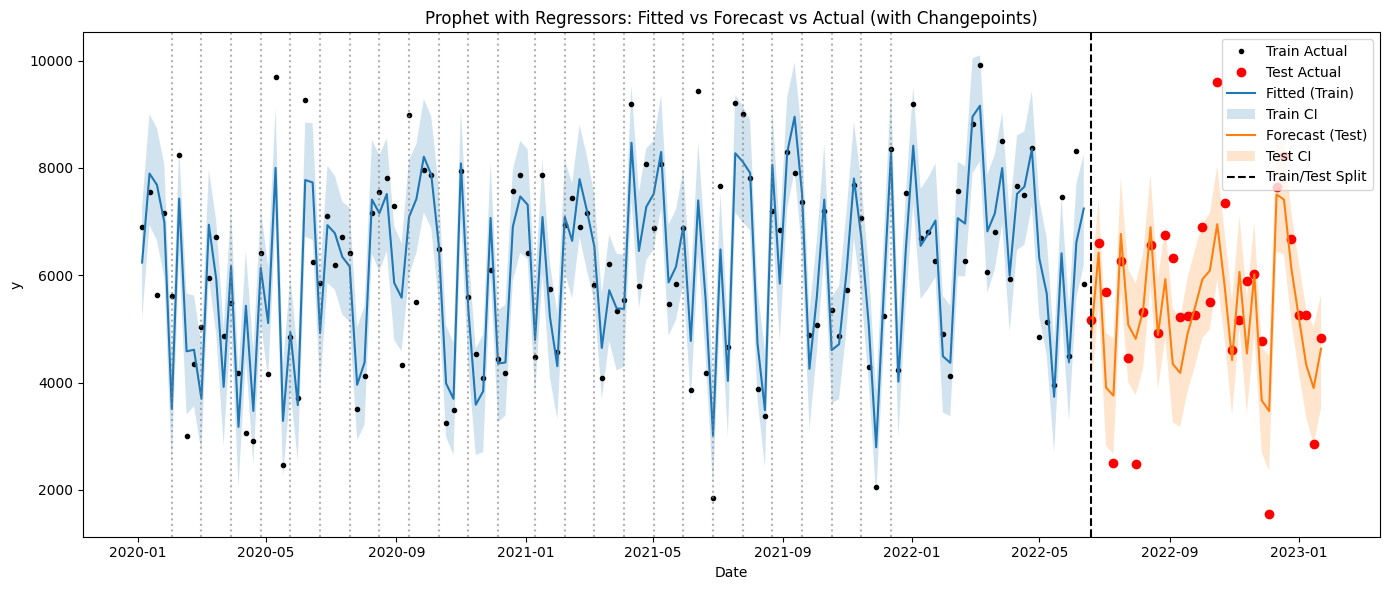

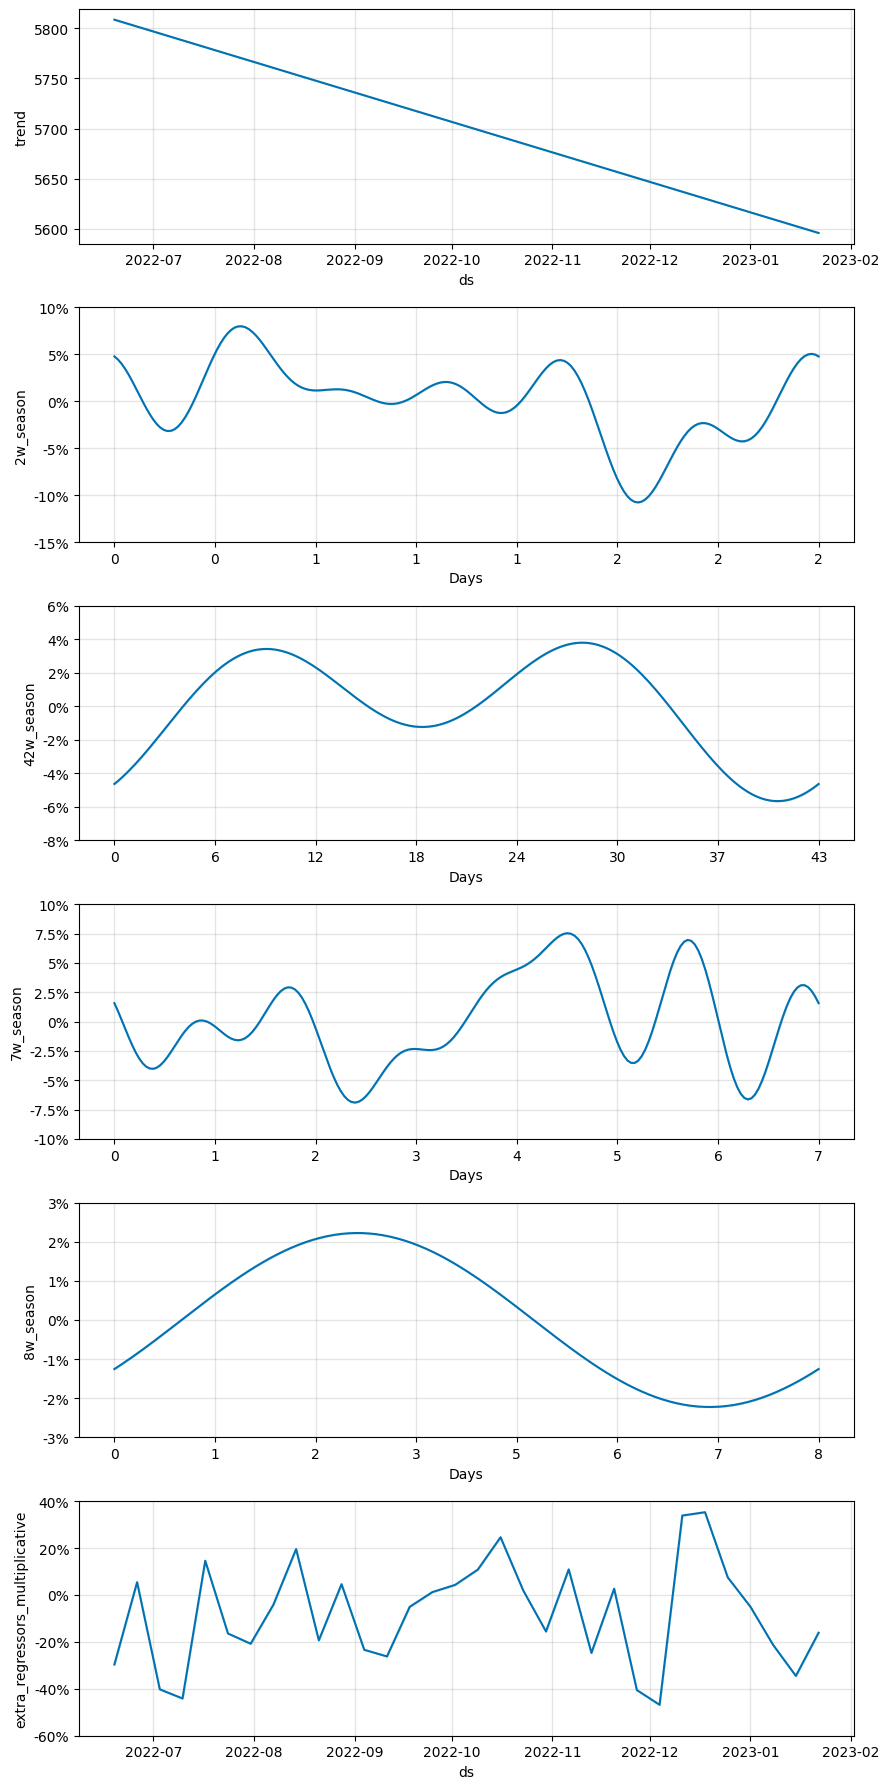

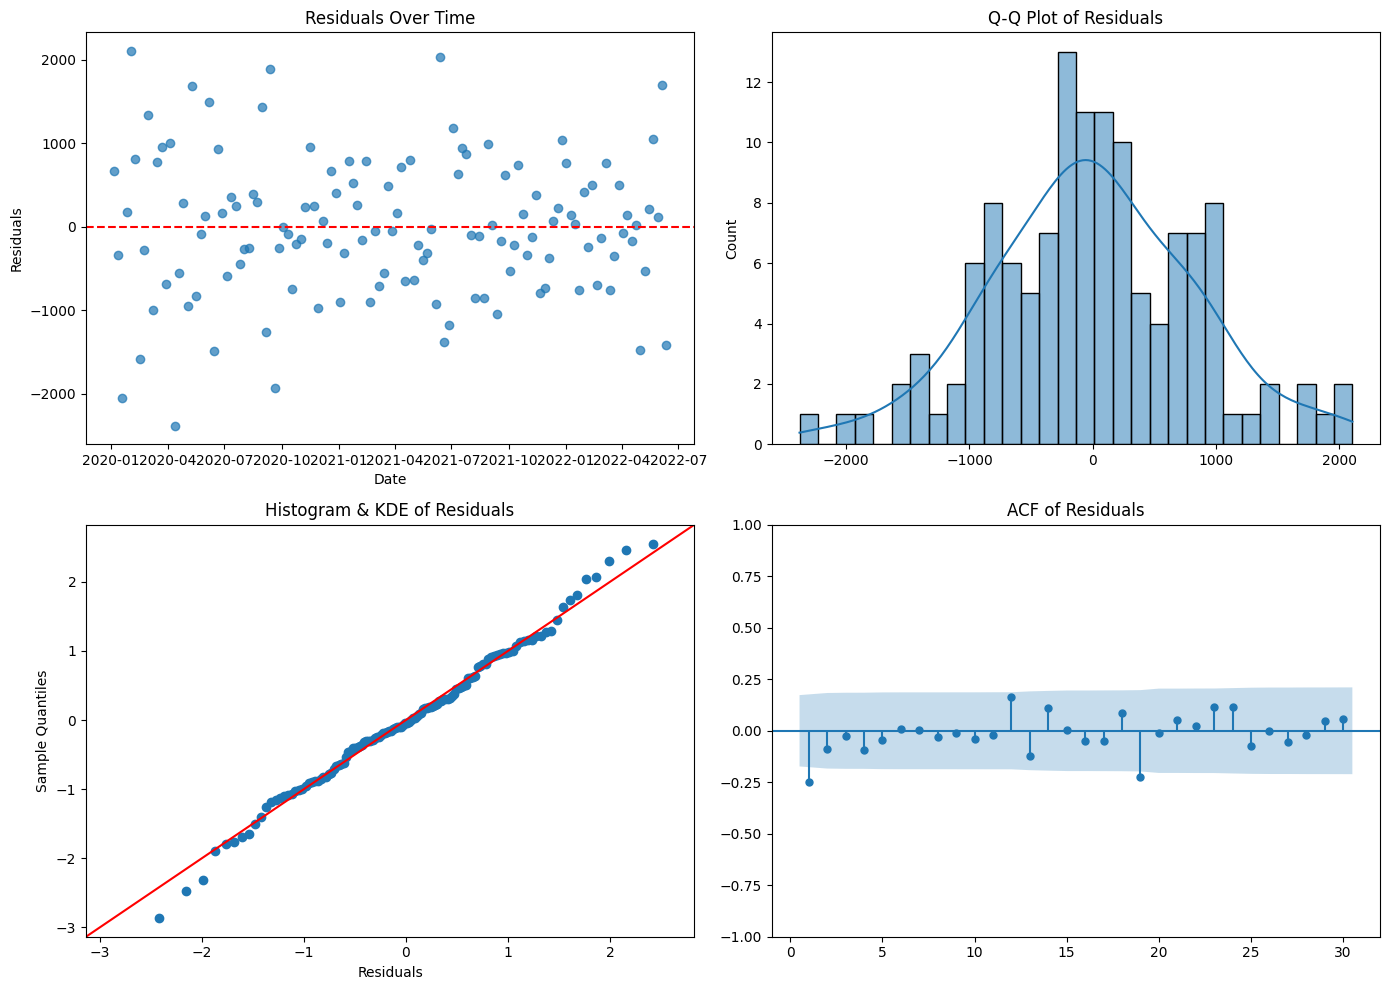

In [52]:
# Build the model
model_mul = Prophet(
    seasonality_mode='multiplicative',
    yearly_seasonality=False, 
    changepoint_prior_scale=0.05,
)
model_mul.add_regressor('x1_spend', prior_scale=0.1)
model_mul.add_regressor('x2_spend', prior_scale=0.1)
# model.add_regressor('x2_spend_lag1', prior_scale=0.05)


# Add seasonality
model_mul.add_seasonality(name='7w_season', period=7.11, fourier_order=7)
model_mul.add_seasonality(name='2w_season', period=2.33, fourier_order=6)
# model_mul.add_seasonality(name='5w_season', period=5.33, fourier_order=1)
model_mul.add_seasonality(name='42w_season', period=42.67, fourier_order=2)
model_mul.add_seasonality(name='8w_season', period=8, fourier_order=1)

# Train the model
model_mul.fit(train_prophet)

# Predict future values
forecast_prophet = model_mul.predict(test_prophet)
y_true = test_prophet['y']
y_pred = forecast_prophet['yhat']

evaluate_forecast_performance(y_true, y_pred)
plot_forecast_with_fit(model_mul, train_prophet, test_prophet, forecast_prophet)
model_mul.plot_components(forecast_prophet)
prophet_residual_diagnostics(model_mul, train_prophet)

**Model Fit Assessment**

This final specification of the Prophet model integrates two exogenous regressors, `x1_spend` and `x2_spend`, alongside multiple domain-informed seasonalities to capture both internal and external drivers of weekly sales behavior. The corresponding Fourier orders are tuned to balance model flexibility and generalization. Multiplicative seasonality is used to allow the amplitude of each component to scale with the level of the series.

**Residual Diagnostics**

The residuals are centered around zero, mostly homoscedastic across time, and free from autocorrelation. The Q–Q plot confirms near-normality, and the histogram of residuals reveals symmetric distribution with only mild deviations in the tails. The absence of significant lags in the ACF plot confirms that the model has effectively captured the autocorrelated structure of the data, even without explicit AR terms.

In [54]:
# Save model
joblib.dump(model_mul, 'multivariate_prophet.pkl')

['multivariate_prophet.pkl']